In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

2. Quantization

In [ ]:
color_image = cv2.imread('/content/sample_data/catlab1.jpg', cv2.IMREAD_COLOR)
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.imread('/content/sample_data/quantization_test.jpg', cv2.IMREAD_GRAYSCALE)

In [3]:
# Linear quantization realization
def quantization(image, threshold, channel='0'):
  quanted_image = np.copy(image)

# Checking if color or gray
  if (len(image.shape) == 3):
      if channel == 'R':
          quanted_image[:,:,0] = (image[:,:,0] // (256 / threshold))
      elif channel == 'G':
          quanted_image[:,:,1] = (image[:,:,1] // (256 / threshold))
      elif channel == 'B':
          quanted_image[:,:,2] = (image[:,:,2] // (256 / threshold))
      return quanted_image
  else:
      quanted_image = (image // (256 / threshold))
      return quanted_image

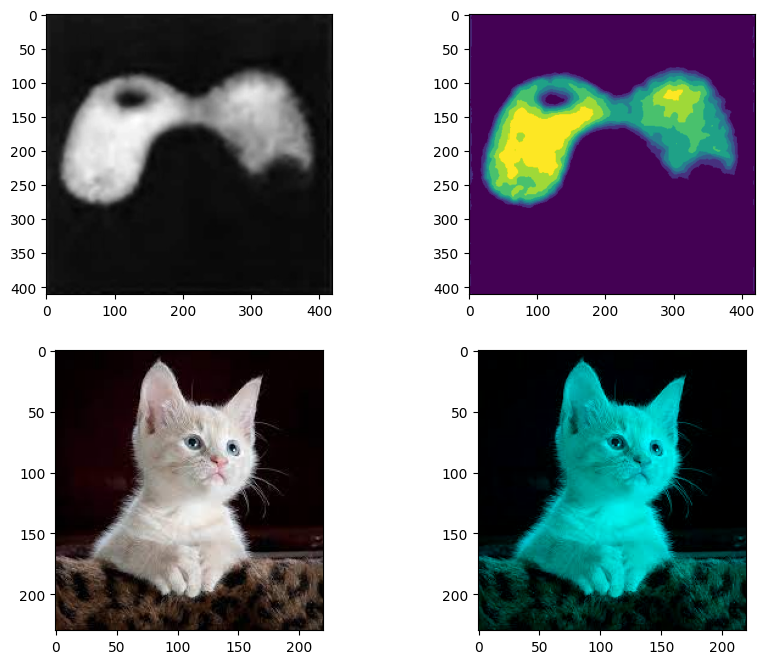

In [ ]:
# Linear quantization demonstration
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(gray_image, 'gray')
plt.subplot(2,2,2)
plt.imshow(quantization(gray_image, 8))
plt.subplot(2,2,3)
plt.imshow(color_image)
plt.subplot(2,2,4)
plt.imshow(quantization(color_image, 2, 'R')) # Quantize using the red channel
plt.show()

3. Otsu

In [10]:
# Assist function
def calculateHist(image):
  hist = [0 for i in range(0,256)]

  for i in range(0, image.shape[0]):
      for j in range(0, image.shape[1]):
        hist[image[i][j]] += 1

  return hist

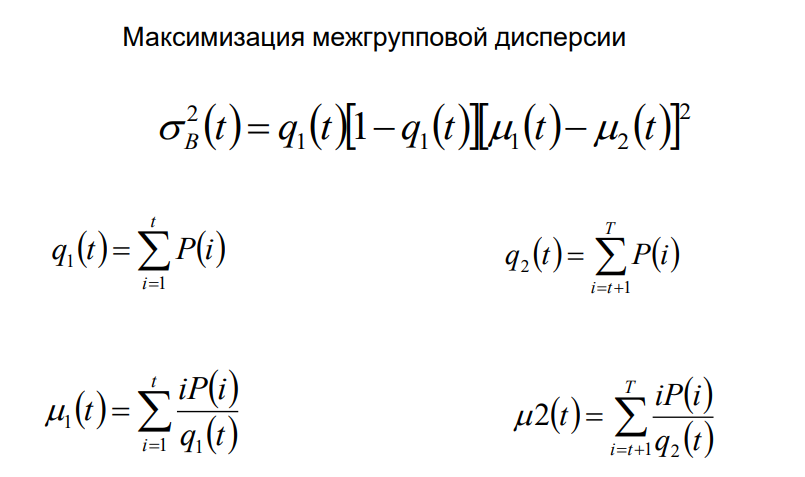

In [46]:
# Otsu method realization
def Otsu_threshold(image):
    hist = calculateHist(image)
    resolution = image.shape[0] * image.shape[1]
    all_intensity_sum = np.sum(np.arange(256) * hist)

    best_threshold = 0
    best_sigma = 0
    first_class_pixel_count = 0
    first_class_intensity = 0
    threshold = 0

    while (threshold < 255):
        threshold += 1

        first_class_pixel_count += hist[threshold]
        first_class_intensity += threshold * hist[threshold]

        if first_class_pixel_count == 0:
            continue

        second_class_pixel_count = resolution - first_class_pixel_count
        if second_class_pixel_count == 0:
            break

        first_class_prob = first_class_pixel_count / resolution
        second_class_prob = 1.0 - first_class_prob

        first_class_mean = first_class_intensity / first_class_pixel_count
        second_class_mean = (all_intensity_sum - first_class_intensity) / second_class_pixel_count

        mean_delta = first_class_mean - second_class_mean
        sigma = first_class_prob * second_class_prob * mean_delta * mean_delta

        if sigma > best_sigma:
            best_sigma = sigma
            best_threshold = threshold

    return best_threshold


In [47]:
# Function for global binarization
def Otsu_global(image):
  threshold = Otsu_threshold(image)
  binary_image = image.copy()

  for i in range(0, image.shape[0]):
      for j in range(0, image.shape[1]):
        if (image[i][j] > threshold):
          binary_image[i][j] = 0
        else:
          binary_image[i][j] = 255

  return binary_image

Threshold: 90


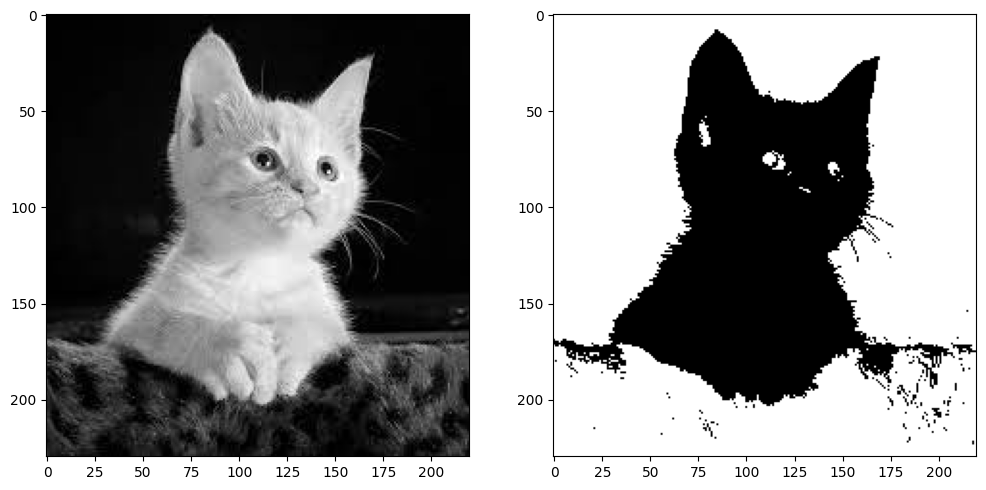

In [48]:
# Otsu global binarization demonstration
image = cv2.imread('/content/sample_data/catlab1.jpg', cv2.IMREAD_GRAYSCALE)

print('Threshold:', Otsu_threshold(image))
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(image, 'gray')
plt.subplot(1,2,2)
plt.imshow(Otsu_global(image), 'gray')
plt.show()

In [49]:
# Otsu local binarization
def Otsu_local(image, parts):
    width_per_part = image.shape[1] // parts
    part_list = []

    for i in range(parts):
        start_width = i * width_per_part
        end_width = (i + 1) * width_per_part
        part = image[:, start_width:end_width]

        print('Threshold',i,'->', Otsu_threshold(part))

        part_list.append(Otsu_global(part))

    return np.hstack(part_list)

Global threshold: 90
Threshold 0 -> 30
Threshold 1 -> 49
Threshold 2 -> 72
Threshold 3 -> 92
Threshold 4 -> 100
Threshold 5 -> 109
Threshold 6 -> 109
Threshold 7 -> 72
Threshold 8 -> 33
Threshold 9 -> 34


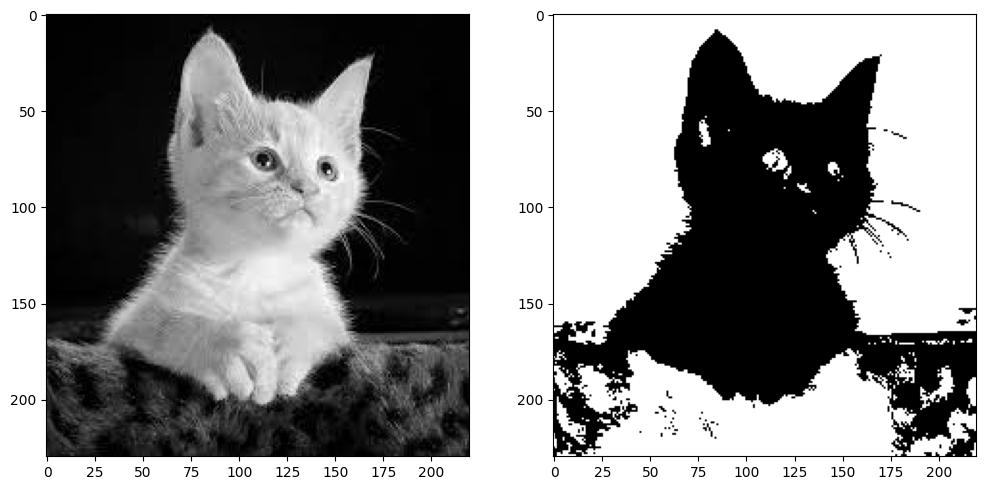

In [50]:
# Otsu local binarization demonstration
image = cv2.imread('/content/sample_data/catlab1.jpg', cv2.IMREAD_GRAYSCALE)

print('Global threshold:', Otsu_threshold(image))
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(image, 'gray')
plt.subplot(1,2,2)
plt.imshow(Otsu_local(image,10), 'gray')
plt.show()

In [51]:
def Otsu_hierarchical(image, depth):
    if depth == 1:
        threshold = Otsu_threshold(image)
        quantized_image = np.zeros_like(image)

        quantized_image[image < threshold] = quantization(image[image < threshold], 2)
        quantized_image[image >= threshold] = quantization(image[image >= threshold], 2)

        return quantized_image
    else:

        mid_x = image.shape[1] // 2
        left_image = image[:, :mid_x]
        right_image = image[:, mid_x:]

        # Рекурсивный вызов для каждой части
        left_quantized = Otsu_hierarchical(left_image, depth - 1)
        right_quantized = Otsu_hierarchical(right_image, depth - 1)

        # Объединение результатов
        quantized_image = np.hstack((left_quantized, right_quantized))

        return quantized_image


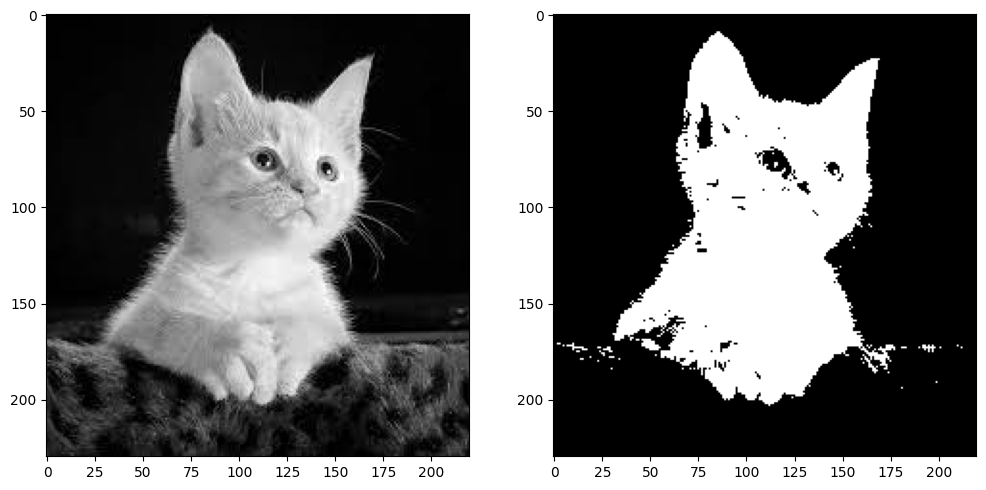

In [52]:
# Otsu_hierarchical quantization demonstration
image = cv2.imread('/content/sample_data/catlab1.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(image, 'gray')
plt.subplot(1,2,2)
plt.imshow(Otsu_hierarchical(image, 2), 'gray')
plt.show()